# 0.0 Import Libraries

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math
import pandas as pd

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

 2013_DFTC
 2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat
 2013_IEEE_GRSS_DF_Contest_LiDAR.mat
 Autoencodermodel.pth
 Autoencodermodel_uh2013_20Ksample.pth
 Autoencodermodel_uh2013_adam_20Ksample.pth
 Autoencodermodel_uh2013_adamp13_20Ksample.pth
 Autoencodermodel_uh2013_adamp9_20Ksample.pth
 Autoencodermodel_uh2013_admp3fuseddata_50Ksample.pth
 Autoencodermodel_uh2013_admp5fuseddata_50Ksample.pth
 Autoencodermodel_uh2013_admp7fuseddata_50Ksample.pth
 Autoencodermodel_uh2013.pth
 Autoencodermodel_uh2013_rms_20Ksample.pth
 Autoencodermodel_uh2013_sgdp11fuseddata_20Ksample.pth
 Autoencodermodel_uh2013_sgdp13_20Ksample.pth
 Autoencodermodel_uh2013_sgdp13fuseddata_20Ksample.pth
 Autoencodermodel_uh2013_sgdp3_20Ksample.pth
 Autoencodermodel_uh2013_sgdp3fuseddata_20Ksample.pth
 Autoencodermodel_uh2013_sgdp3fuseddata_50Ksample.pth
 Autoencodermodel_uh2013_sgdp5_20Ksample.pth
 Autoencodermodel_uh2013_sgdp5fuseddata_20Ksample.pth
 Autoencodermodel_uh2013_sgdp5fuseddata_50Ksample.pth
 Autoenco

In [ ]:
#define path
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [ ]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat(path+'GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


# 2.0 Data Preprocessing & Dataloader Preparation

In [ ]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 'training_sample', 198, 'test_sample', 1053,  'total', 1251),
    (2, "Stressed grass",'training_sample', 190, 'test_sample', 1064,  'total', 1254),
    (3, "Synthetic grass", 'training_sample', 192, 'test_sample', 505,  'total', 697),
    (4, "Trees", 'training_sample', 188, 'test_sample', 1058,  'total', 1244),
    (5, "Soil",'training_sample', 186, 'test_sample', 1056,  'total', 1242),
    (6, "Water", 'training_sample', 182, 'test_sample', 141,  'total', 325),
    (7, "Residential", 'training_sample', 196, 'test_sample', 1072,  'total', 1268),
    (8, "Commercial", 'training_sample', 191, 'test_sample', 1053,  'total', 1244),
    (9, "Road", 'training_sample', 193, 'test_sample', 1059,  'total', 1252),
    (10, "Highway", 'training_sample', 191, 'test_sample', 1036,  'total', 1227),
    (11, "Railway", 'training_sample', 181, 'test_sample', 1054,  'total', 1235),
    (12, "Parking lot 1", 'training_sample', 192, 'test_sample', 1041,  'total', 1233),
    (13, "Parking lot 2", 'training_sample', 184, 'test_sample',285,  'total', 469),
    (14, "Tennis court",'training_sample', 181, 'test_sample', 247,  'total', 428),
    (15, "Running track", 'training_sample', 187, 'test_sample', 473,  'total', 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name,
                             'training_sample': training_sample,
                             'test_sample': test_sample,
                             "total_samples": total}
              for class_number, class_name, _, training_sample, _, test_sample, _, total in class_info}

print(class_dict)


{1: {'class_name': 'Healthy grass', 'training_sample': 198, 'test_sample': 1053, 'total_samples': 1251}, 2: {'class_name': 'Stressed grass', 'training_sample': 190, 'test_sample': 1064, 'total_samples': 1254}, 3: {'class_name': 'Synthetic grass', 'training_sample': 192, 'test_sample': 505, 'total_samples': 697}, 4: {'class_name': 'Trees', 'training_sample': 188, 'test_sample': 1058, 'total_samples': 1244}, 5: {'class_name': 'Soil', 'training_sample': 186, 'test_sample': 1056, 'total_samples': 1242}, 6: {'class_name': 'Water', 'training_sample': 182, 'test_sample': 141, 'total_samples': 325}, 7: {'class_name': 'Residential', 'training_sample': 196, 'test_sample': 1072, 'total_samples': 1268}, 8: {'class_name': 'Commercial', 'training_sample': 191, 'test_sample': 1053, 'total_samples': 1244}, 9: {'class_name': 'Road', 'training_sample': 193, 'test_sample': 1059, 'total_samples': 1252}, 10: {'class_name': 'Highway', 'training_sample': 191, 'test_sample': 1036, 'total_samples': 1227}, 11: 

### 2.1  Samples Extraction

In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["total_samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["total_samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)


### 2.2 Training samples extraction

In [ ]:
# Create training_samples_dict based on class_dict
training_samples_dict = {class_num: class_info["training_sample"] for class_num, class_info in class_dict.items()}

# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined
# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)



hsi_training_samples shape: (2832, 9, 9, 144)
lidar_training_samples shape: (2832, 9, 9, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)


### 2.1.1 Augmentation training samples

In [ ]:
import numpy as np
from scipy.ndimage import rotate

def augment_training_data(hsi_training_data, lidar_training_data, training_labels, rotations=[45, 90, 135], flip_up_down=True, flip_left_right=True):
    augmented_hsi = []
    augmented_lidar = []
    augmented_labels = []

    for hsi, lidar, label in zip(hsi_training_data, lidar_training_data, training_labels):
        # Original data
        augmented_hsi.append(hsi)
        augmented_lidar.append(lidar)
        augmented_labels.append(label)

        # Rotations
        for angle in rotations:
            hsi_rotated = rotate(hsi, angle, axes=(0, 1), reshape=False, mode='nearest')
            lidar_rotated = rotate(lidar, angle, axes=(0, 1), reshape=False, mode='nearest')

            augmented_hsi.append(hsi_rotated)
            augmented_lidar.append(lidar_rotated)
            augmented_labels.append(label)

        # Flip up-down
        if flip_up_down:
            hsi_flipped_ud = np.flipud(hsi)
            lidar_flipped_ud = np.flipud(lidar)

            augmented_hsi.append(hsi_flipped_ud)
            augmented_lidar.append(lidar_flipped_ud)
            augmented_labels.append(label)

        # Flip left-right
        if flip_left_right:
            hsi_flipped_lr = np.fliplr(hsi)
            lidar_flipped_lr = np.fliplr(lidar)

            augmented_hsi.append(hsi_flipped_lr)
            augmented_lidar.append(lidar_flipped_lr)
            augmented_labels.append(label)

    return np.array(augmented_hsi), np.array(augmented_lidar), np.array(augmented_labels)

# Augmenting the training samples
augmented_hsi_training_samples, augmented_lidar_training_samples, augmented_training_labels = augment_training_data(hsi_training_samples, lidar_training_samples, training_labels)

# Print shapes to verify the augmented training data
print('Augmented HSI training samples shape:', augmented_hsi_training_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_training_samples.shape)
print('Augmented training labels shape:', augmented_training_labels.shape)

Augmented HSI training samples shape: (16992, 9, 9, 144)
Augmented LiDAR training samples shape: (16992, 9, 9, 1)
Augmented training labels shape: (16992,)


### 2.3 Selected bands

In [ ]:
bands_aug=[41, 87, 75, 90, 54, 20, 119, 58, 138, 1, 33, 126, 129, 38, 82, 84, 107, 133, 14, 88, 59, 68, 125, 15, 17, 57, 110, 24, 74, 141, 96, 46, 95, 11, 128, 27, 108, 28, 140, 32, 65, 13, 10, 25, 111, 30, 93, 77, 39, 106]

In [ ]:
# AutoEncoder+FusedMask+AVGPooling
top_30_seed42=[29, 137, 47, 50, 1, 133, 140, 30, 87, 141, 40, 107, 41, 3, 134, 103, 142, 96, 14, 108, 143, 80, 36, 70, 15, 31, 35, 4, 24, 130] #Selected bands for seed 42:
top_30_seed0=[141, 143, 36, 108, 3, 31, 14, 102, 122, 133, 140, 50, 103, 135, 29, 24, 41, 21, 134, 96, 58, 40, 80, 4, 130, 35, 30, 71, 107, 137] #Selected bands for seed 0:
top_30_seed123=[35, 133, 108, 122, 3, 47, 107, 50, 58, 140, 142, 41, 143, 29, 103, 137, 141, 134, 30, 36, 96, 40, 31, 4, 130, 14, 80, 70, 17, 24]

top_25_seed42=[122, 59, 143, 35, 4, 140, 118, 3, 40, 58, 17, 133, 50, 14, 107, 47, 141, 96, 94, 134, 36, 41, 108, 103, 130] #Selected bands for seed 42:
top_25_seed0=[108, 31, 19, 50, 71, 122, 3, 133, 17, 141, 103, 47, 140, 58, 143, 107, 101, 134, 40, 96, 14, 35, 36, 100, 130] #Selected bands for seed 0:
top_25_seed123= [111, 133, 87, 3, 41, 30, 35, 50, 107, 96, 44, 103, 134, 40, 19, 140, 95, 36, 143, 31, 14, 122, 135, 108, 130]


top_20_seed42=[94, 130, 103, 10, 96, 3, 107, 45, 50, 108, 17, 140, 14, 143, 42, 31, 111, 87, 134, 36] #Selected bands for seed 42:
top_20_seed0=[108, 133, 131, 140, 36, 71, 31, 50, 35, 3, 96, 103, 47, 143, 141, 107, 134, 87, 59, 130] #Selected bands for seed 0:
top_20_seed123=[141, 134, 31, 108, 96, 3, 131, 130, 49, 17, 103, 50, 35, 38, 140, 107, 40, 87, 92, 36]

top_15_seed42=[108, 107, 131, 50, 135, 36, 140, 130, 103, 87, 3, 96, 47, 42, 134] #Selected bands for seed 42:
top_15_seed0=[96, 103, 130, 135, 3, 107, 108, 14, 47, 50, 17, 36, 35, 134, 140] #Selected bands for seed 0:
top_15_seed123= [111, 50, 107, 87, 103, 96, 130, 29, 140, 10, 141, 36, 3, 134, 108]

top_10_seed42=[34, 130, 96, 3, 131, 103, 36, 107, 50, 141] #Selected bands for seed 42:
top_10_seed0=[107, 34, 131, 50, 141, 103, 3, 36, 130, 96] #Selected bands for seed 0:
top_10_seed123= [36, 34, 50, 131, 103, 3, 130, 96, 107, 141]

top_5_seed42=[107, 45, 21, 50, 103] #Selected bands for seed 42:
top_5_seed0=[45, 107, 21, 50, 103] #Selected bands for seed 0:
top_5_seed123=[50, 45, 107, 103, 21]

top_1_seed42=[103] #Selected bands for seed 42:
top_1_seed0=[103] #Selected bands for seed 0:
top_1_seed123=[103]

In [ ]:
#Cross_AutoEncoder
top_25=[38, 127, 53, 131, 105, 50, 113, 32, 109, 7, 3, 82, 20, 103, 54, 9, 15, 140, 43, 90, 52, 104, 41, 10, 95] #alpha=1, beta=0.0.5
top_20=[37, 53, 138, 50, 14, 113, 116, 109, 79, 102, 20, 101, 57, 82, 80, 1, 143, 4, 42, 122] #10/12 Running alpha=0.8, beta=0.2
top_15=[65, 41, 101, 53, 82, 120, 109, 113, 95, 38, 127, 103, 20, 50, 131] #10/12 Running alpha=0.8, beta=0.2
top_10=[16, 32, 80, 53, 79, 116, 124, 113, 132, 109] #10/12 Running alpha=0.8, beta=0.2
top_5=[79, 138, 16, 26, 53] #10/12 Running alpha=0.8, beta=0.2
top_1=[131]

In [ ]:
#Cross_AutoEncoder
top_10=[16, 32, 80, 53, 79, 116, 124, 113, 132, 109] #10/12 Running alpha=0.8, beta=0.2

In [ ]:
#Cross_AutoEncoder
top_20=[37, 53, 138, 50, 14, 113, 116, 109, 79, 102, 20, 101, 57, 82, 80, 1, 143, 4, 42, 122] #10/12 Running alpha=0.8, beta=0.2

In [ ]:
# Autoencoder input shape(200,800,144)
bands_en_p9= [4, 38,  95,  58,  32, 143,  54,  17, 132,  56,115, 107,  44 ,  1,  79, 124,  53, 141, 81,  28]

In [ ]:
# Autoencoder inputshape(150,800,144)
bands_en_p9=[9, 63, 141, 123, 107,   2,  22, 140,  36,  69,  12,  17 ,115, 136,  86 , 96 , 34 , 70,54, 135]

In [ ]:
# AUtoEncoder Unsupervided Learning
bands_un_p9=[117, 118, 114, 116, 115, 111, 112, 110, 113, 119, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100]

In [ ]:
#bands 9 using more traing data
#bands_p9=[24, 71, 138, 83, 43, 63, 139, 133, 40, 47, 22, 131, 128, 134, 75, 16, 70, 125, 7, 93,15, 19, 23, 104, 39, 55, 3, 44, 1, 110, 136, 99, 120, 116, 60, 51, 77, 35, 24, 41, 66, 79, 101, 143, 5, 69, 30, 85, 65, 45, 10]
#Patch_size=9
bands_p9= [42, 131, 71, 17, 56, 114, 47, 53, 124, 52, 139, 135, 50, 16, 48, 8, 11, 73, 99, 2, 63, 28, 88, 116, 32, 14, 133, 57, 102, 137, 15, 79, 132, 105, 120, 93, 80, 43, 81, 138, 142, 31, 97, 130, 34, 26, 110, 27, 134, 69, 39, 78, 37, 106, 77, 25, 29, 89, 95, 65, 141, 129, 18, 62, 91, 121, 58, 127, 118, 1, 19, 36, 30, 20, 128, 44, 104, 24, 107, 117, 0, 84, 21, 112, 4, 68, 125, 5, 103, 45, 33, 70, 111, 109, 23, 94, 136, 64, 12, 143, 85, 72, 122, 119, 83, 82, 38, 108, 66, 100, 55, 35, 40, 49, 101, 51, 3, 59, 9, 54, 41, 140, 86, 7, 10, 75, 46, 22, 98, 87, 13, 92, 90, 76, 61, 60, 115, 113, 123, 96, 126, 67, 6, 74]

In [ ]:
#band_ASPS_22=[2,13,18,26,27,42,44,57,60,68,69,79,88,91,101,105,110,116,126,127,135,137]
bands_asps=[2, 5, 7, 16, 1, 47, 34, 42, 10, 38, 49, 15, 18, 17, 13, 19, 20, 14, 9, 12, 11, 22, 8, 6, 4, 3, 21, 24, 23, 48, 46, 45, 44, 43, 41, 40, 39, 37, 36, 35, 33, 32, 31, 30, 29, 28, 27, 26, 25, 0]
# # ASPS band selction
# bands_asps=[17, 20,  3, 12, 23,  6, 11, 29,  1 , 2,  4 , 5 , 7 , 8,  9 ,10, 14, 13 ,28, 15, 16 ,18, 19, 21,
#  22, 24, 25, 26, 27,  0]

In [ ]:
# opbs band selection obtained on 09232023
#bands_opbs=[ 51,  87,  21, 143,  67,   8,  40,  75, 133 , 84 ,100 ,142, 130,  29,  46,  16,  73, 141,109, 140,  63,  83,  68,  30, 139,  97,   0, 138,  56, 136]
bands_opbs=[51, 87, 21, 143, 67, 8, 40, 75, 133, 84, 100, 142, 130, 29, 46, 16, 73, 141, 109, 140, 63, 83, 68, 30, 139, 97, 0, 138, 56, 136, 79, 14, 137, 117, 28, 131, 17, 69, 47, 33, 92, 135, 134, 3, 72, 127, 50, 128, 11, 132]

In [ ]:
#TRC_OC_FDPC
# bands_trc=[21,  4, 15, 20, 28,  7, 10, 18, 27, 24,  5, 11, 16,  8,  0, 65 ,55, 56, 57, 58, 59, 60, 61, 62,
#  63, 64 ,73 ,66, 67 ,68]
# Obtained on 09232023
bands_trc=[47, 27, 16, 40, 35, 5, 31, 18, 15, 21, 26, 7, 9, 36, 3, 17, 48, 11, 69, 4, 33, 32, 75, 68, 70, 142, 72, 73, 74, 143, 76, 77, 78, 79, 80, 81, 82, 66, 67, 55, 65, 64, 49, 50, 51, 52, 53, 54, 84, 56]

In [ ]:
# LRR_BS
#bands_lrr=[ 67, 143,  45 , 51,  50,  49 , 48,  47,  46 , 44,  53,  43,  42 , 41,  39,  38,  37 , 52,54,  35,  55,  56 , 57,  58 , 59,  60,  61,  62,  63 , 64]
# Obtained data on 09232023
bands_lrr=[67, 143, 45, 51, 50, 49, 48, 47, 46, 44, 53, 43, 42, 41, 39, 38, 37, 52, 54, 35, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 36, 34, 142, 8, 14, 13, 12, 11, 10, 9, 7, 16, 6, 5, 4, 3]


In [ ]:
# #mrmr
# bands_mrmr=[  0,   1 ,  2 ,  3  , 4 ,  5  , 7, 123 ,122 ,  6 ,120,   9, 124,  8, 125,  10, 121,  12,139,  11, 127,  40 ,126,  36 , 71,  16,  14,  84,  13 , 70]
#REF
#bands_ref=[ 22,  23 , 24,  25 , 27  ,28 , 29 , 30 , 31 , 36 , 40 , 57 , 58 , 59 , 63 , 64,  65,  66 , 67 , 80 , 81 , 82 , 86,  87 , 88 , 89 , 90 ,105 ,107 ,108]
#RLFFC
#bands_rlffc=[0, 1, 2, 3, 4,5, 7, 22, 23,24, 25, 27, 28,29,30,31,123 ,122, 6 ,120, 9, 124,8, 125, 10, 121, 12,36, 40,57]

In [ ]:
#BS_nets obtianed on 09232023
#bands_bsnet=[122, 29, 84, 31, 32, 44, 19, 42, 69, 108, 1, 41, 56, 49, 61, 125, 57, 28, 47, 38, 62, 72, 80, 70, 119, 97, 94, 0, 10, 102]
bands_bsnet=[118, 127, 40, 105, 90, 18, 70, 82, 8, 143, 115, 1, 22, 75, 80, 51, 21, 103, 113, 26, 25, 44, 77, 93, 16, 27, 0, 91, 140, 45, 56, 76, 114, 61, 4, 79, 137, 67, 83, 9, 129, 78, 10, 11, 132, 32, 106, 87, 6, 88]


In [ ]:
#RLFFC
bands_rlffc=[29,93,124,54,14,108,97,6,135,43,130,73,80,118,41,22,111,88,60,35,70,74,83,19,11,102,57,9,47,45,37,100,12,32,25,52,120,17,77,51,95,72,105,79,64,90,76,20,68,50]

In [ ]:
# HSI Self_attention top 50 band index
bands_hsi_lid_self=[116,  25,  85, 113, 143,  94,  41, 120, 119,  76,  58,  23,  18,  11,10,  64, 118,  20,  75,  30,  59,  24,  14,   7,  22,  90,  16,  72, 47, 124,  73, 114,  32, 127,  13,  69,   0,  97,  39,  78, 132,  79, 112,   5,  83,  43,  99,  49,  29, 134]

In [ ]:
#HSI+LiDAR_self_attention top 50 bands
bands_hsi_self=[ 43, 106,  81, 137,  93, 119,  62,   5,   1,  91,  31,  56, 120,  79, 77,  35,  18,  74,  40, 118,  90,  59,  98, 135,  52,  17,  78,  69, 44, 124, 141,  73,  57, 133,  65,  36,  80, 112,  38, 108,  48,  12,70, 123,  37,  26,  72,  99,  87, 104]

In [ ]:
band_indices = np.arange(144)

In [ ]:
augmented_hsi_train_samples=augmented_hsi_training_samples
augmented_lidar_train_samples=augmented_lidar_training_samples
augmented_train_labels=augmented_training_labels

hsi_test_samples=hsi_test_samples
lidar_test_samples=lidar_test_samples
test_labels=test_labels

# Print out
print('Augmented HSI training samples shape:', augmented_hsi_train_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_train_samples.shape)
print('Augmented training labels shape:', augmented_train_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

# Concatenating the HSI samples
augmented_hsi_samples = np.concatenate((augmented_hsi_train_samples, hsi_test_samples), axis=0)
# Concatenating the LiDAR samples
augmented_lidar_samples = np.concatenate((augmented_lidar_train_samples, lidar_test_samples), axis=0)
# Concatenating the labels
augmented_labels = np.concatenate((augmented_training_labels, test_labels), axis=0)

# Print out the new shapes
print('Augmented HSI samples shape:', augmented_hsi_samples.shape)
print('Augmented LiDAR samples shape:', augmented_lidar_samples.shape)
print('Augmented labels shape:', augmented_labels.shape)


Augmented HSI training samples shape: (16992, 9, 9, 144)
Augmented LiDAR training samples shape: (16992, 9, 9, 1)
Augmented training labels shape: (16992,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)
Augmented HSI samples shape: (29189, 9, 9, 144)
Augmented LiDAR samples shape: (29189, 9, 9, 1)
Augmented labels shape: (29189,)


#2.5 SVM Evaluation Ensulte

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
from tqdm import tqdm

def evaluate_svm_with_bands(X_train, y_train, X_test, y_test):
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

    # Initialize and train SVM classifier
    svm_classifier = SVC(kernel='rbf', gamma='scale')
    svm_classifier.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = svm_classifier.predict(X_test_scaled)

    # Calculate metrics
    oa = accuracy_score(y_test, y_pred)
    aa = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    return oa, aa, kappa

# Loop over different sets of band indices
#band_indices_sets = [top_1_seed42, top_5_seed42, top_10_seed42, top_15_seed42, top_20_seed42, top_25_seed42, top_30_seed42, top_35_seed42, top_40_seed42, top_45_seed42, top_50_seed42]
band_indices_sets = [bands_hsi_self[:1], bands_hsi_self[:5], bands_hsi_self[:10], bands_hsi_self[:15], bands_hsi_self[:20], bands_hsi_self[:25], bands_hsi_self[:30], bands_hsi_self[:35],
                    bands_hsi_self[:40], bands_hsi_self[:45], bands_hsi_self[:50]]
#band_indices_sets = [bands_hsi_lid_self[:1], bands_hsi_lid_self[:5], bands_hsi_lid_self[:10], bands_hsi_lid_self[:15], bands_hsi_lid_self[:20], bands_hsi_lid_self[:25], bands_hsi_lid_self[:30], bands_hsi_self[:35],
 #                 bands_hsi_lid_self[:40], bands_hsi_lid_self[:45], bands_hsi_lid_self[:50]]
#band_indices_sets = [bands_p9[:1], bands_p9[:5], bands_p9[:10], bands_p9[:15], bands_p9[:20], bands_p9[:25], bands_p9[:30], bands_p9[:35],
 #                    bands_p9[:40], bands_p9[:45], bands_p9[:50]]
#band_indices = np.arange(144)
#band_indices_sets = [band_indices[:1], band_indices[:50], band_indices[:144]]
#band_indices_sets = [bands_bsnet[:1], bands_bsnet[:5], bands_bsnet[:10], bands_bsnet[:15], bands_bsnet[:20], bands_bsnet[:25], bands_bsnet[:30], bands_bsnet[:35],
 #                   bands_bsnet[:40], bands_bsnet[:45], bands_bsnet[:50]]
#band_indices_sets = [bands_trc[:1], bands_trc[:5], bands_trc[:10], bands_trc[:15], bands_trc[:20], bands_trc[:25], bands_trc[:30], bands_trc[:35],
 #                   bands_trc[:40], bands_trc[:45], bands_trc[:50]]
#band_indices_sets = [bands_asps[:1], bands_asps[:5], bands_asps[:10], bands_asps[:15], bands_asps[:20], bands_asps[:25], bands_asps[:30], bands_asps[:35],bands_asps[:40], bands_asps[:45], bands_asps[:50]]
#band_indices_sets = [bands_opbs[:1], bands_opbs[:5], bands_opbs[:10], bands_opbs[:15], bands_opbs[:20], bands_opbs[:25], bands_opbs[:30], bands_opbs[:35],bands_opbs[:40], bands_opbs[:45], bands_opbs[:50]]
#band_indices_sets = [bands_lrr[:1], bands_lrr[:5], bands_lrr[:10], bands_lrr[:15], bands_lrr[:20], bands_lrr[:25], bands_lrr[:30], bands_lrr[:35],bands_lrr[:40], bands_lrr[:45], bands_lrr[:50]]
#band_indices_sets = [bands_aug[:1], bands_aug[:5], bands_aug[:10], bands_aug[:15], bands_aug[:20], bands_aug[:25], bands_aug[:30], bands_aug[:35],bands_aug[:40], bands_aug[:45], bands_aug[:50]]

# Loop over different sets of band indices with a progress bar
results_hsi_lidar = {}
results_hsi_only = {}

for band_indices in tqdm(band_indices_sets, desc="Processing"):
    # Extract the corresponding bands from the HSI training and test samples
    selected_hsi_train = hsi_training_samples[:,:,:,band_indices]
    selected_hsi_test = hsi_test_samples[:,:,:,band_indices]
    #  #Augmented samples
    # selected_hsi_train = augmented_hsi_training_samples[:,:,:,band_indices]
    # selected_hsi_test = hsi_test_samples[:,:,:,band_indices]
    # lidar_training_samples=augmented_lidar_training_samples
    # training_labels=augmented_training_labels

    # Method 1: HSI+LiDAR
    selected_hsi_lidar_train = np.concatenate([selected_hsi_train, lidar_training_samples], axis=3)
    selected_hsi_lidar_test = np.concatenate([selected_hsi_test, lidar_test_samples], axis=3)
    oa, aa, kappa = evaluate_svm_with_bands(selected_hsi_lidar_train, training_labels, selected_hsi_lidar_test, test_labels)
    results_hsi_lidar[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    print(f"HSI+LiDAR - Band indices {band_indices}: OA={oa:.5f}, AA={aa:.5f}, Kappa={kappa:.5f}")

    # # Method 2: HSI only
    # oa, aa, kappa = evaluate_svm_with_bands(selected_hsi_train, training_labels, selected_hsi_test, test_labels)
    # results_hsi_only[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    # print(f"HSI Only - Band indices {band_indices}: OA={oa:.5f}, AA={aa:.5f}, Kappa={kappa:.5f}")


Processing:   9%|▉         | 1/11 [00:08<01:28,  8.89s/it]

HSI+LiDAR - Band indices [43]: OA=0.67148, AA=0.70697, Kappa=0.64559


Processing:  18%|█▊        | 2/11 [00:22<01:44, 11.61s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93]: OA=0.87620, AA=0.89277, Kappa=0.86566


Processing:  27%|██▋       | 3/11 [00:46<02:16, 17.09s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91]: OA=0.90965, AA=0.92094, Kappa=0.90193


Processing:  36%|███▋      | 4/11 [01:20<02:46, 23.81s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77]: OA=0.90637, AA=0.91866, Kappa=0.89838


Processing:  45%|████▌     | 5/11 [02:13<03:27, 34.51s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118]: OA=0.91006, AA=0.92237, Kappa=0.90239


Processing:  55%|█████▍    | 6/11 [03:19<03:45, 45.02s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52]: OA=0.90325, AA=0.91710, Kappa=0.89501


Processing:  64%|██████▎   | 7/11 [04:38<03:44, 56.23s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52, 17, 78, 69, 44, 124]: OA=0.90727, AA=0.92022, Kappa=0.89937


Processing:  73%|███████▎  | 8/11 [06:10<03:22, 67.51s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52, 17, 78, 69, 44, 124, 141, 73, 57, 133, 65]: OA=0.90366, AA=0.91703, Kappa=0.89546


Processing:  82%|████████▏ | 9/11 [07:55<02:39, 79.52s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52, 17, 78, 69, 44, 124, 141, 73, 57, 133, 65, 36, 80, 112, 38, 108]: OA=0.90153, AA=0.91465, Kappa=0.89315


Processing:  91%|█████████ | 10/11 [09:50<01:30, 90.24s/it]

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52, 17, 78, 69, 44, 124, 141, 73, 57, 133, 65, 36, 80, 112, 38, 108, 48, 12, 70, 123, 37]: OA=0.90514, AA=0.91762, Kappa=0.89706


Processing: 100%|██████████| 11/11 [12:01<00:00, 65.56s/it] 

HSI+LiDAR - Band indices [43, 106, 81, 137, 93, 119, 62, 5, 1, 91, 31, 56, 120, 79, 77, 35, 18, 74, 40, 118, 90, 59, 98, 135, 52, 17, 78, 69, 44, 124, 141, 73, 57, 133, 65, 36, 80, 112, 38, 108, 48, 12, 70, 123, 37, 26, 72, 99, 87, 104]: OA=0.90284, AA=0.91584, Kappa=0.89457


# 3.0 Classification _ SVM

hsi_training_samples shape: (2832, 9, 9, 144)
lidar_training_samples shape: (2832, 9, 9, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)

In [ ]:
# Convert the list of patches and labels into arrays
hsi_samples = np.array(augmented_hsi_samples)
lidar_samples = np.array(augmented_lidar_samples)
labels = np.array(augmented_labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

# Convert lists back to numpy arrays
hsi_training_samples = np.array(augmented_hsi_train_samples)
lidar_training_samples = np.array(augmented_lidar_train_samples)
training_labels = np.array(augmented_train_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

hsi_samples shape: (29189, 9, 9, 144)
lidar_samples shape: (29189, 9, 9, 1)
labels shape: (29189,)
hsi_training_samples shape: (16992, 9, 9, 144)
lidar_training_samples shape: (16992, 9, 9, 1)
training_labels shape: (16992,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)


In [ ]:
# Define the band indices you're interested in
band_indices=bands_aug[:5]
#band_indices=top_5_seed42
#band_indices=top_1_seed0
#band_indices=top_5_seed123
#band_indices=bands_en_p9[:1]
#band_indices = bands_p9[:1]
#band_indices=bands_un_p9[:10]
#band_indices=bands_lrr[:50]
#band_indices=bands_asps[:35]
#band_indices=bands_opbs[:50]
#band_indices=bands_bsnet[:35]
#band_indices=bands_trc[:1]
#band_indices=bands_rlffc[:25]

# Extract the corresponding bands from the HSI samples
selected_hsi_samples = hsi_samples[:,:,:, band_indices]
selected_lidar_samples = lidar_samples
label=labels
selected_training_lables=training_labels
selected_test_labels=test_labels
print('label shape:', label.shape)
print('selected_training_lables shape:', selected_training_lables.shape)
print('selected_test_labels shape:', selected_test_labels.shape)

selected_hsi_train_samples = hsi_training_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  lidar_training_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data
# # Concatenate the data
selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

label shape: (29189,)
selected_training_lables shape: (16992,)
selected_test_labels shape: (12197,)
selected_hsi_train_samples  shape: (16992, 9, 9, 5)
selected_hsi_test_sample shape: (12197, 9, 9, 5)
selected_lidar_train shape: (16992, 9, 9, 1)
selected_lidar_test shape: (12197, 9, 9, 1)
selected_hsi_samples shape: (29189, 9, 9, 5)
selected_lidar_samples shape: (29189, 9, 9, 1)
selected_hsi_lidar_samples shape: (29189, 9, 9, 6)
selected_hsi_lidar_train_samples shape: (16992, 9, 9, 6)
selected_hsi_lidar_test_samples shape: (12197, 9, 9, 6)


In [ ]:
# # Concatenate the data
selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)


X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=augmented_training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


selected_hsi_samples shape: (29189, 9, 9, 5)
selected_lidar_samples shape: (29189, 9, 9, 1)
selected_hsi_lidar_samples shape: (29189, 9, 9, 6)
selected_hsi_lidar_train_samples shape: (16992, 9, 9, 6)
selected_hsi_lidar_test_samples shape: (12197, 9, 9, 6)
X_train shape: (16992, 9, 9, 6)
X_test shape: (12197, 9, 9, 6)
y_train shape: (16992,)
y_test shape: (12197,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report, cohen_kappa_score

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape X_train_scaled and X_test_scaled to 2D (already done during scaling)
X_train_2d = X_train_scaled
X_test_2d = X_test_scaled

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf')  # You can choose other kernels like 'linear' or 'poly'

# Train the classifier
svm_classifier.fit(X_train_2d, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test_2d)

# Output classification report
print(classification_report(y_test, y_pred))

# Compute and output overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print('Overall accuracy:', overall_accuracy)

# Compute and output average
average_accuracy = balanced_accuracy_score(y_test, y_pred)
print('Average accuracy:', average_accuracy)

# Output kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa:', kappa)

              precision    recall  f1-score   support

           1       1.00      0.84      0.91      1053
           2       0.86      1.00      0.93      1064
           3       0.80      1.00      0.89       505
           4       0.98      0.97      0.98      1056
           5       0.99      0.98      0.98      1056
           6       0.99      0.98      0.98       143
           7       0.93      0.93      0.93      1072
           8       0.94      0.74      0.83      1053
           9       0.94      0.86      0.90      1059
          10       0.72      0.82      0.77      1036
          11       0.88      0.71      0.79      1054
          12       0.74      0.94      0.83      1041
          13       0.90      0.84      0.87       285
          14       0.90      1.00      0.95       247
          15       1.00      1.00      1.00       473

    accuracy                           0.89     12197
   macro avg       0.90      0.91      0.90     12197
weighted avg       0.90   

# Method 2 CNN

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from scipy.io import loadmat
import mat73

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time
import time

seed(11)

# Convert X_Train, X_test, y_train, y_test to suit 1DCNN

In [ ]:
# USing Augmentation training sample to test
# Define the band indices you're interested in
band_indices = bands_aug[:1]
#band_indices = bands_aug1[:50]
#band_indices = bands_p9[:50]
#band_indices=bands_lrr[:1]
#band_indices=bands_asps[:35]
#band_indices=bands_opbs[:1]
#band_indices=bands_trc[:1]
#band_indices=bands_bsnet[:1]
#band_indices=bands_rlffc[:50]
#band_indices = np.arange(64)

# Extract the corresponding bands from the HSI samples
selected_hsi_samples = augmented_hsi_samples[:,:,:, band_indices]
selected_lidar_samples = augmented_lidar_samples
label=augmented_labels
selected_training_lables=augmented_train_labels
selected_test_labels=test_labels
print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('label shape:', label.shape)
print('selected_training_lables shape:', selected_training_lables.shape)
print('selected_test_labels shape:', selected_test_labels.shape)

selected_hsi_train_samples = augmented_hsi_train_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  augmented_lidar_train_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data
# # Concatenate the data
# Concatenate the data along axis 3
selected_hsi_lidar_samples = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

# # Concatenate the data
selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=augmented_training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

selected_hsi_samples shape: (29189, 9, 9, 1)
selected_lidar_samples shape: (29189, 9, 9, 1)
label shape: (29189,)
selected_training_lables shape: (16992,)
selected_test_labels shape: (12197,)
selected_hsi_train_samples  shape: (16992, 9, 9, 1)
selected_hsi_test_sample shape: (12197, 9, 9, 1)
selected_lidar_train shape: (16992, 9, 9, 1)
selected_lidar_test shape: (12197, 9, 9, 1)
selected_hsi_lidar_samples shape: (29189, 9, 9, 2)
selected_lidar_samples shape: (29189, 9, 9, 1)
selected_hsi_lidar_samples shape: (29189, 9, 9, 2)
selected_hsi_lidar_train_samples shape: (16992, 9, 9, 2)
selected_hsi_lidar_test_samples shape: (12197, 9, 9, 2)
selected_hsi_samples shape: (29189, 9, 9, 1)
selected_lidar_samples shape: (29189, 9, 9, 1)
selected_hsi_lidar_samples shape: (29189, 9, 9, 2)
selected_hsi_lidar_train_samples shape: (16992, 9, 9, 2)
selected_hsi_lidar_test_samples shape: (12197, 9, 9, 2)
X_train shape: (16992, 9, 9, 2)
X_test shape: (12197, 9, 9, 2)
y_train shape: (16992,)
y_test shape:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Store the original shapes
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_test_shape = X_test.shape    # (samples, height, width, channels)

# Reshape for standardization (2D)
X_train_reshaped = X_train.reshape(-1, original_train_shape[1]*original_train_shape[2]*original_train_shape[3])
X_test_reshaped = X_test.reshape(-1, original_test_shape[1]*original_test_shape[2]*original_test_shape[3])

# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_reshaped)
X_test_standardized = scaler.transform(X_test_reshaped)

# Reshape back to original 4D shape
X_train = X_train_standardized.reshape(original_train_shape)
X_test = X_test_standardized.reshape(original_test_shape)

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


After standardization:
X_train shape: (16992, 9, 9, 2)
X_test shape: (12197, 9, 9, 2)


In [ ]:
X_train_channels = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2], X_train.shape[3])  # Reshaping to (9900, 81, 3)
X_test_channels = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2], X_test.shape[3])    # Reshaping to (53687, 81, 3)
print('X_train_channels:',X_train_channels.shape)
print('X_test_channels:',X_test_channels.shape)

# For 1D CNN, we need to add an extra dimension
X_train = X_train_channels
X_test = X_test_channels
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
ip_shape = X_train[1].shape
n_outputs = 11

print('ip_shape shape:', ip_shape)
print('n_outputs:', n_outputs)

y_train=augmented_training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

y_train=augmented_training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

# Build CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D

model = Sequential(name = 'aug_DFTC2013_Fusion')
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =ip_shape, name = 'Layer1'))
#model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

# Use n_outputs as the number of neurons in the output layer
model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))

model.summary()

Model: "aug_DFTC2013_Fusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 79, 64)            448       
                                                                 
 Layer2 (Conv1D)             (None, 77, 64)            12352     
                                                                 
 Layer3 (Conv1D)             (None, 75, 64)            12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 37, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 37, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 35, 32)            6176      
                                               

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='aug_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'aug_DFTC2013_Fusion_logs/{time.time()}')

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard],
    verbose=1
)

Epoch 1/50
531/531 [==============================] - 24s 41ms/step - loss: 1.5065 - accuracy: 0.4665 - val_loss: 1.0692 - val_accuracy: 0.5790
Epoch 2/50
531/531 [==============================] - 30s 56ms/step - loss: 0.8277 - accuracy: 0.6943 - val_loss: 0.6802 - val_accuracy: 0.7371
Epoch 3/50
531/531 [==============================] - 23s 43ms/step - loss: 0.6489 - accuracy: 0.7545 - val_loss: 0.6475 - val_accuracy: 0.7527
Epoch 4/50
531/531 [==============================] - 20s 38ms/step - loss: 0.5303 - accuracy: 0.7957 - val_loss: 0.5110 - val_accuracy: 0.8127
Epoch 5/50
531/531 [==============================] - 21s 40ms/step - loss: 0.4526 - accuracy: 0.8307 - val_loss: 0.5220 - val_accuracy: 0.8192
Epoch 6/50
531/531 [==============================] - 22s 42ms/step - loss: 0.4131 - accuracy: 0.8483 - val_loss: 0.3879 - val_accuracy: 0.8656
Epoch 7/50
531/531 [==============================] - 19s 36ms/step - loss: 0.3722 - accuracy: 0.8595 - val_loss: 0.4192 - val_accuracy:

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import numpy as np

# Load the best model saved by ModelCheckpoint
best_model = load_model('aug_DFTC2013_Fusion_Model.h5')

# Get the predictions from the best model
y_pred = best_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred = np.argmax(y_pred, axis=1) + 1

# y_test is already in original form
y_test_original = y_test

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_original, y_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test_original, y_pred)
print("Overall Accuracy: ", overall_accuracy)

# Calculate average accuracy
average_accuracy = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))
print("Average Accuracy: ", average_accuracy)

# Calculate kappa coefficient
kappa = cohen_kappa_score(y_test_original, y_pred)
print("Cohen's Kappa Coefficient: ", kappa)

382/382 [==============================] - 4s 11ms/step
Overall Accuracy:  0.9549069443305731
Average Accuracy:  0.9638834183497585
Cohen's Kappa Coefficient:  0.9510483580430513


#3.5 Structure CNN, band sets and data together

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import numpy as np
import time

def evaluate_cnn_with_bands(X_train, y_train, X_test, y_test, ip_shape, n_outputs):
    # Build the CNN model
    model = Sequential(name='aug_DFTC2013_Fusion')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=ip_shape, name='Layer1'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Layer2'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Layer3'))
    model.add(MaxPooling1D(pool_size=2, name='MaxPooling_Layer1'))
    model.add(Dropout(0.4, name='Dropout1'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name='Layer4'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name='Layer5'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name='Layer6'))
    model.add(MaxPooling1D(pool_size=2, name='MaxPooling_Layer2'))
    model.add(Dropout(0.4, name='Dropout2'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(25, activation='relu', name='DenseLayer'))
    model.add(Dense(n_outputs, activation='softmax', name='OutputLayer'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath='aug_DFTC2013_Fusion_Model.h5', monitor='val_loss', mode='min', save_best_only=True)
    tensorboard = TensorBoard(log_dir=f'aug_DFTC2013_Fusion_logs/{time.time()}')

    # Convert labels to categorical
    y_train_encoded = to_categorical(y_train - 1)  # Assuming your labels start from 1
    y_test_encoded = to_categorical(y_test - 1)

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stop, checkpoint, tensorboard], verbose=1)

    # Load the best model and evaluate
    best_model = load_model('aug_DFTC2013_Fusion_Model.h5')
    y_pred = best_model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1) + 1  # Convert predictions back to original form

    # Calculate metrics
    confusion_mtx = confusion_matrix(y_test, y_pred)
    oa = accuracy_score(y_test, y_pred)  # Overall Accuracy
    aa = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))  # Average Accuracy
    kappa = cohen_kappa_score(y_test, y_pred)  # Cohen's Kappa Coefficient

    return oa, aa, kappa


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Define your sets of band indices
band_indices_sets = [bands_p3[:1], bands_p3[:5], bands_p3[:10], bands_p3[:15], bands_p3[:20], bands_p3[:25], bands_p3[:30], bands_p3[:35], bands_p3[:40], bands_p3[:45], bands_p3[:50]]

results_cnn_hsi_lidar = {}
results_cnn_hsi_only = {}

for band_indices in tqdm(band_indices_sets, desc="Processing"):
    # Extract the corresponding bands from the HSI training and test samples
    selected_hsi_train_samples = augmented_hsi_train_samples[:, :, :, band_indices]
    selected_hsi_test_samples = hsi_test_samples[:, :, :, band_indices]
    selected_lidar_train = augmented_lidar_train_samples
    selected_lidar_test = lidar_test_samples

    # Concatenate HSI and LiDAR data
    selected_hsi_lidar_train_samples = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
    selected_hsi_lidar_test_samples = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

    # Reshape for 1D CNN
    X_train_channels = selected_hsi_lidar_train_samples.reshape(selected_hsi_lidar_train_samples.shape[0], -1, selected_hsi_lidar_train_samples.shape[3])
    X_test_channels = selected_hsi_lidar_test_samples.reshape(selected_hsi_lidar_test_samples.shape[0], -1, selected_hsi_lidar_test_samples.shape[3])

    # Store the original shapes
    original_train_shape = X_train_channels.shape  # (samples, height*width, channels)
    original_test_shape = X_test_channels.shape   # (samples, height*width, channels)

    # Reshape for standardization (2D)
    X_train_reshaped = X_train_channels.reshape(-1, original_train_shape[1]*original_train_shape[2])
    X_test_reshaped = X_test_channels.reshape(-1, original_test_shape[1]*original_test_shape[2])

    # Standardize
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train_reshaped)
    X_test_standardized = scaler.transform(X_test_reshaped)

    # Reshape back to original shape for 1D CNN
    X_train = X_train_standardized.reshape(original_train_shape)
    X_test = X_test_standardized.reshape(original_test_shape)

    # Prepare labels
    y_train = augmented_training_labels
    y_test = test_labels
    y_train_encoded = to_categorical(y_train - 1)
    y_test_encoded = to_categorical(y_test - 1)

    # Define input shape and number of outputs for CNN
    ip_shape = X_train[1].shape
    n_outputs = y_train_encoded.shape[1]

    # Evaluate CNN with the current set of bands
    oa, aa, kappa = evaluate_cnn_with_bands(X_train, y_train_encoded, X_test, y_test_encoded, ip_shape, n_outputs)

    # Store the results
    results_cnn_hsi_lidar[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}


# 4.0 Comparison Experiments

### 4.0.1 Ablation Study

In [ ]:
data_values = """0.9040	0.9172	0.8958	0.8948	0.9100	0.8858	0.8792	0.8981	0.8689	0.8424	0.8673	0.8290	0.8441	0.8684	0.8308	0.8445	0.8695	0.8313	0.8499	0.8736	0.8371	0.8532	0.8770	0.8408	0.8595	0.8822	0.8476	0.8752	0.8934	0.8646	0.6918	0.7361	0.6677
0.8419	0.8622	0.8285	0.8422	0.8618	0.8288	0.8460	0.8650	0.8330	0.8387	0.8599	0.8251	0.8369	0.8584	0.8232	0.8414	0.8624	0.8281	0.8476	0.7675	0.8348	0.8586	0.8763	0.8466	0.8614	0.8776	0.8496	0.7681	0.7994	0.7492	0.6619	0.7014	0.6355
0.9084	0.9217	0.9006	0.9089	0.9221	0.9011	0.9073	0.9207	0.8994	0.9067	0.9204	0.8987	0.9061	0.9199	0.8981	0.9004	0.9155	0.8919	0.9038	0.9173	0.8955	0.9040	0.9175	0.8958	0.9111	0.9233	0.9035	0.9045	0.9171	0.8963	0.6745	0.7214	0.6495
0.9000	0.9148	0.8915	0.9002	0.9150	0.8917	0.9015	0.9159	0.8931	0.9033	0.9179	0.8951	0.9015	0.9152	0.8931	0.8851	0.9002	0.8752	0.8537	0.8726	0.8412	0.8420	0.8628	0.8286	0.8282	0.8515	0.8138	0.8192	0.8424	0.8041	0.6762	0.7221	0.6510
0.9049	0.9165	0.8968	0.9057	0.9162	0.8971	0.9069	0.9175	0.8990	0.9062	0.9174	0.8983	0.9039	0.9174	0.8958	0.9051	0.9182	0.8972	0.9054	0.9184	0.8974	0.9046	0.9178	0.8965	0.9025	0.9140	0.8942	0.8669	0.8840	0.8556	0.7426	0.7632	0.7181
0.8925	0.9080	0.8834	0.9056	0.9157	0.8975	0.9016	0.9152	0.8932	0.9035	0.9168	0.8952	0.9006	0.9145	0.8921	0.9014	0.9152	0.8930	0.8945	0.9097	0.8855	0.8974	0.9116	0.8887	0.9075	0.9189	0.8996	0.9061	0.9183	0.8981	0.6703	0.7166	0.6448
0.9020	0.9167	0.8937	0.9028	0.9179	0.8946	0.9019	0.9164	0.8936	0.9022	0.9164	0.8939	0.9003	0.9152	0.8918	0.9010	0.9157	0.8925	0.9056	0.9193	0.8976	0.9106	0.9231	0.9030	0.9079	0.9203	0.9000	0.8631	0.8819	0.8515	0.7952	0.8237	0.7785
0.9081	0.9220	0.9003	0.9104	0.9237	0.9027	0.9136	0.9262	0.9062	0.9190	0.9304	0.9121	0.9201	0.9301	0.9133	0.9193	0.9284	0.9124	0.9198	0.9283	0.9124	0.9019	0.9167	0.8935	0.8938	0.9107	0.8848	0.9079	0.9210	0.9000	0.6539	0.6983	0.6269
0.9209	0.9349	0.9141	0.9215	0.9354	0.9147	0.9204	0.9342	0.9136	0.9246	0.9374	0.9181	0.9242	0.9373	0.9177	0.9266	0.9392	0.9203	0.9253	0.9378	0.9189	0.9251	0.9378	0.9186	0.9317	0.9427	0.9259	0.9202	0.9335	0.9134	0.6939	0.7242	0.6693"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9040, 0.9172, 0.8958, 0.8948, 0.9100, 0.8858, 0.8792, 0.8981, 0.8689, 0.8424, 0.8673, 0.8290, 0.8441, 0.8684, 0.8308, 0.8445, 0.8695, 0.8313, 0.8499, 0.8736, 0.8371, 0.8532, 0.8770, 0.8408, 0.8595, 0.8822, 0.8476, 0.8752, 0.8934, 0.8646, 0.6918, 0.7361, 0.6677
0.8419, 0.8622, 0.8285, 0.8422, 0.8618, 0.8288, 0.8460, 0.8650, 0.8330, 0.8387, 0.8599, 0.8251, 0.8369, 0.8584, 0.8232, 0.8414, 0.8624, 0.8281, 0.8476, 0.7675, 0.8348, 0.8586, 0.8763, 0.8466, 0.8614, 0.8776, 0.8496, 0.7681, 0.7994, 0.7492, 0.6619, 0.7014, 0.6355
0.9084, 0.9217, 0.9006, 0.9089, 0.9221, 0.9011, 0.9073, 0.9207, 0.8994, 0.9067, 0.9204, 0.8987, 0.9061, 0.9199, 0.8981, 0.9004, 0.9155, 0.8919, 0.9038, 0.9173, 0.8955, 0.9040, 0.9175, 0.8958, 0.9111, 0.9233, 0.9035, 0.9045, 0.9171, 0.8963, 0.6745, 0.7214, 0.6495
0.9000, 0.9148, 0.8915, 0.9002, 0.9150, 0.8917, 0.9015, 0.9159, 0.8931, 0.9033, 0.9179, 0.8951, 0.9015, 0.9152, 0.8931, 0.8851, 0.9002, 0.8752, 0.8537, 0.8726, 0.8412, 0.8420, 0.8628, 0.8286, 0.8282, 0.8515, 0.8

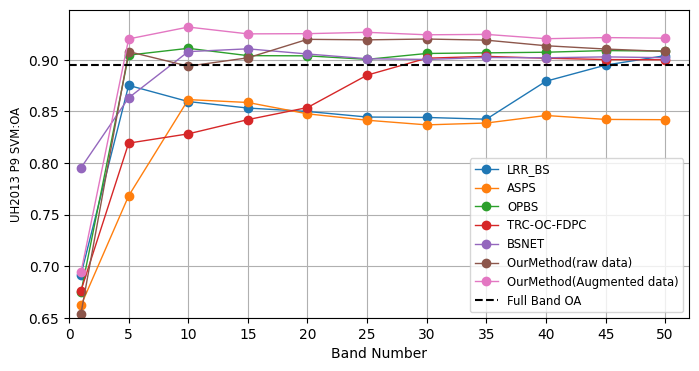

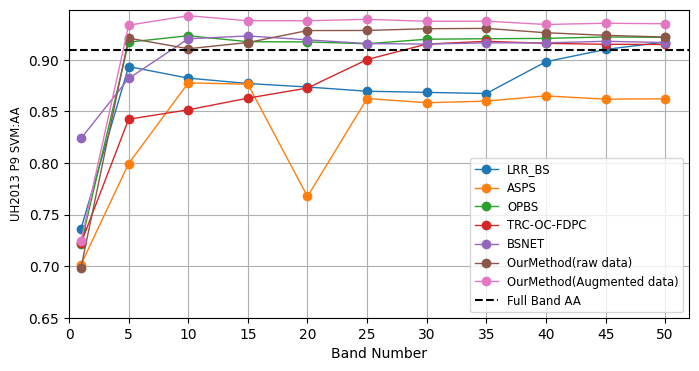

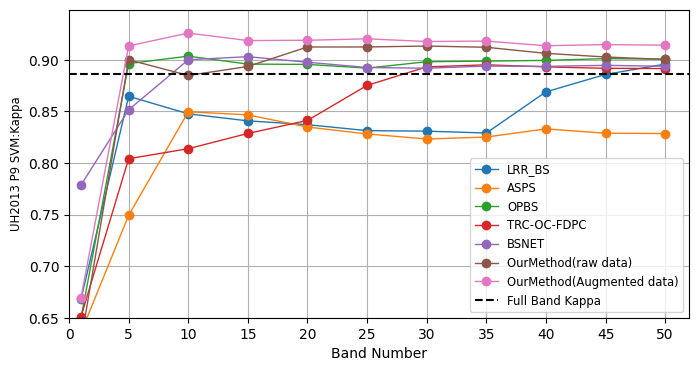

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data
data = {
    'Band Number': [50,50,50, 45,45,45, 40, 40,40,35,35,35, 30,30,30, 25,25, 25,  20,20,20, 15,15,15, 10,10,10, 5,5,5, 1,1,1] ,
    "Metrics": ['OA', 'AA', 'Kappa']*11,
    'LRR_BS': [0.9040, 0.9172, 0.8958, 0.8948, 0.9100, 0.8858, 0.8792, 0.8981, 0.8689, 0.8424, 0.8673, 0.8290, 0.8441, 0.8684, 0.8308, 0.8445, 0.8695, 0.8313, 0.8499, 0.8736, 0.8371, 0.8532, 0.8770, 0.8408, 0.8595, 0.8822, 0.8476, 0.8752, 0.8934, 0.8646, 0.6918, 0.7361, 0.6677],
'ASPS': [0.8419, 0.8622, 0.8285, 0.8422, 0.8618, 0.8288, 0.8460, 0.8650, 0.8330, 0.8387, 0.8599, 0.8251, 0.8369, 0.8584, 0.8232, 0.8414, 0.8624, 0.8281, 0.8476, 0.7675, 0.8348, 0.8586, 0.8763, 0.8466, 0.8614, 0.8776, 0.8496, 0.7681, 0.7994, 0.7492, 0.6619, 0.7014, 0.6355],
'OPBS': [0.9084, 0.9217, 0.9006, 0.9089, 0.9221, 0.9011, 0.9073, 0.9207, 0.8994, 0.9067, 0.9204, 0.8987, 0.9061, 0.9199, 0.8981, 0.9004, 0.9155, 0.8919, 0.9038, 0.9173, 0.8955, 0.9040, 0.9175, 0.8958, 0.9111, 0.9233, 0.9035, 0.9045, 0.9171, 0.8963, 0.6745, 0.7214, 0.6495],
'TRC-OC-FDPC': [0.9000, 0.9148, 0.8915, 0.9002, 0.9150, 0.8917, 0.9015, 0.9159, 0.8931, 0.9033, 0.9179, 0.8951, 0.9015, 0.9152, 0.8931, 0.8851, 0.9002, 0.8752, 0.8537, 0.8726, 0.8412, 0.8420, 0.8628, 0.8286, 0.8282, 0.8515, 0.8138, 0.8192, 0.8424, 0.8041, 0.6762, 0.7221, 0.6510],
'BSNET': [0.9020, 0.9167, 0.8937, 0.9028, 0.9179, 0.8946, 0.9019, 0.9164, 0.8936, 0.9022, 0.9164, 0.8939, 0.9003, 0.9152, 0.8918, 0.9010, 0.9157, 0.8925, 0.9056, 0.9193, 0.8976, 0.9106, 0.9231, 0.9030, 0.9079, 0.9203, 0.9000, 0.8631, 0.8819, 0.8515, 0.7952, 0.8237, 0.7785],
'OurMethod(raw data)': [0.9081, 0.9220, 0.9003, 0.9104, 0.9237, 0.9027, 0.9136, 0.9262, 0.9062, 0.9190, 0.9304, 0.9121, 0.9201, 0.9301, 0.9133, 0.9193, 0.9284, 0.9124, 0.9198, 0.9283, 0.9124, 0.9019, 0.9167, 0.8935, 0.8938, 0.9107, 0.8848, 0.9079, 0.9210, 0.9000, 0.6539, 0.6983, 0.6269],
'OurMethod(Augmented data)': [0.9209, 0.9349, 0.9141, 0.9215, 0.9354, 0.9147, 0.9204, 0.9342, 0.9136, 0.9246, 0.9374, 0.9181, 0.9242, 0.9373, 0.9177, 0.9266, 0.9392, 0.9203, 0.9253, 0.9378, 0.9189, 0.9251, 0.9378, 0.9186, 0.9317, 0.9427, 0.9259, 0.9202, 0.9335, 0.9134, 0.6939, 0.7242, 0.6693]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['LRR_BS', 'ASPS', 'OPBS', 'TRC-OC-FDPC', 'BSNET', 'OurMethod(raw data)', 'OurMethod(Augmented data)']

full_bands = {'OA': 0.8948, 'AA': 0.9091, 'Kappa': 0.8859}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6500, 0.9485)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

#4.1.0 Plot Based on SVM Test (LiDAR +HSI)

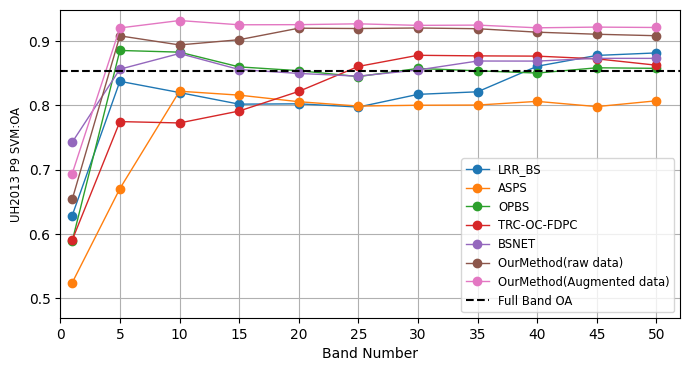

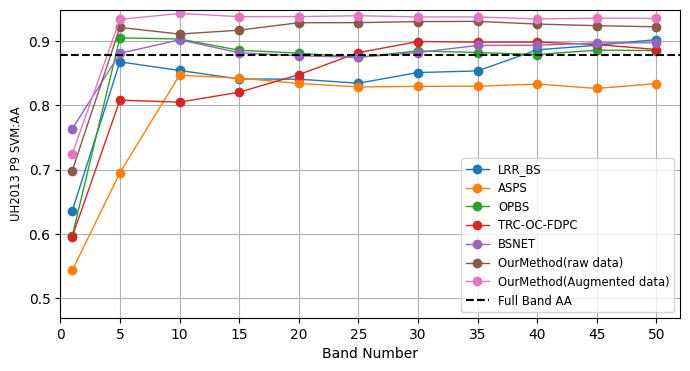

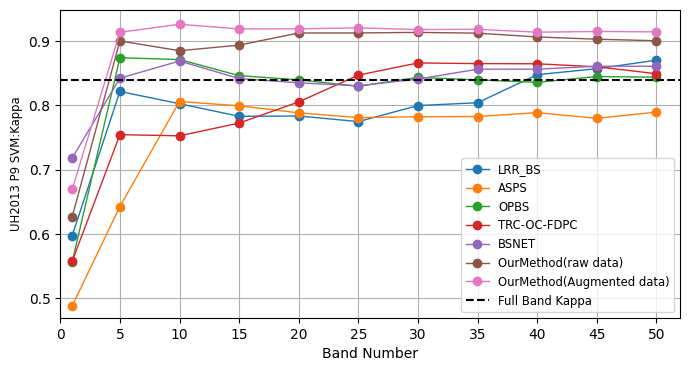

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'LRR_BS': [0.8814, 0.8775, 0.8607, 0.8210, 0.8170, 0.7973, 0.8023, 0.8018, 0.8198, 0.8373, 0.6288,
               0.9021, 0.8933, 0.8862, 0.8534, 0.8509, 0.8343, 0.8406, 0.8409, 0.8541, 0.8675, 0.6359,
               0.8701, 0.8569, 0.8476, 0.804, 0.7996, 0.7747, 0.7834, 0.7829, 0.8025, 0.8215, 0.5977],
    'ASPS': [0.807, 0.798, 0.8061, 0.8004, 0.8001, 0.7988, 0.8056, 0.8158, 0.8219, 0.6706, 0.52433,
             0.8338, 0.8262, 0.833, 0.8296, 0.8294, 0.8286, 0.8339, 0.8423, 0.8468, 0.6952, 0.5434,
             0.7894, 0.7798, 0.7886, 0.7826, 0.7822, 0.7809, 0.7883, 0.7992, 0.8059, 0.6427, 0.4885],
    'OPBS': [0.8574, 0.8583, 0.8501, 0.8536,  0.8573, 0.8446, 0.8538, 0.8597, 0.8826, 0.8852, 0.5891,
             0.885, 0.8857, 0.8789, 0.882,  0.8846, 0.8745,  0.881, 0.8856, 0.903, 0.9048, 0.597,
             0.8437, 0.8447, 0.8357, 0.8395,  0.8434, 0.8295,  0.8396, 0.8461, 0.8711, 0.8739, 0.557],
    'TRC-OC-FDPC': [0.8623, 0.8722, 0.8764, 0.8768, 0.8777, 0.8604,  0.8216, 0.7911, 0.7726, 0.7747, 0.5906,
                    0.8867, 0.8945, 0.8982, 0.8981, 0.8991, 0.8818,  0.8476, 0.8203, 0.8049, 0.808, 0.5957,
                    0.8491, 0.8598, 0.8645, 0.8648,  0.8658, 0.8469,  0.8053, 0.7724, 0.7526, 0.7544, 0.5578],
    'BSNET': [0.8729, 0.873, 0.8687, 0.8688,  0.8549, 0.8453,  0.8495, 0.8556, 0.8805, 0.8561, 0.7426,
              0.8971, 0.8969, 0.8933, 0.893, 0.882, 0.8746,  0.8769, 0.8817, 0.9018, 0.8807, 0.7632,
              0.8606, 0.8607, 0.8561, 0.8561,  0.8408, 0.8304,  0.8349, 0.8416, 0.8688, 0.8421, 0.7181],
    'OurMethod(raw data)': [0.9081, 0.9104, 0.9136, 0.9190,  0.9201, 0.9193, 0.9198,0.9019,  0.8938, 0.9079, 0.6539,
                           0.9220, 0.9237, 0.9262, 0.9304,  0.9301, 0.9284,0.9283,  0.9167, 0.9107, 0.9210, 0.6983,
                           0.9003, 0.9027, 0.9062, 0.9121,  0.9133,0.9124, 0.9124, 0.8935,  0.8848, 0.9000, 0.6269],
    'OurMethod(Augmented data)': [0.9209,0.9215,0.9204,0.9246,0.9242,0.9266,0.9253,0.9251,0.9317,0.9202,0.6939,
                 0.9349,0.9354,0.9342,0.9374,0.9373,0.9392,0.9378,0.9378,0.9427,0.9335,0.7242,
                 0.9141,0.9147,0.9136,0.9181,0.9177,0.9203,0.9189,0.9186,0.9259,0.9134,0.6693]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['LRR_BS', 'ASPS', 'OPBS', 'TRC-OC-FDPC', 'BSNET', 'OurMethod(raw data)', 'OurMethod(Augmented data)']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.47, 0.9485)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

#4.2 Plot Based on CNN (HSI+LIDAR)





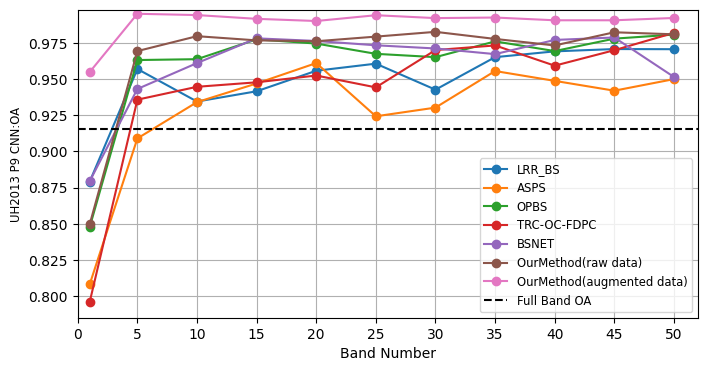

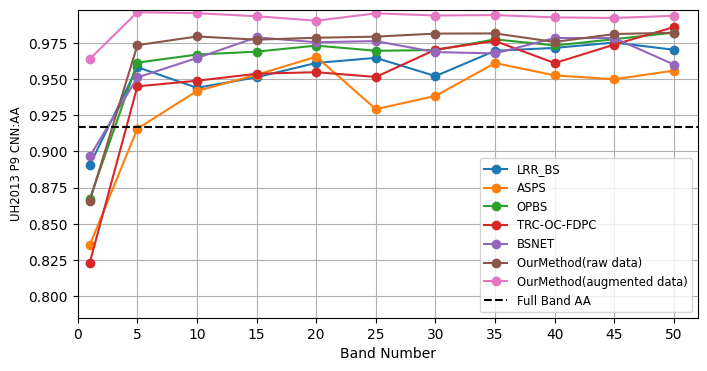

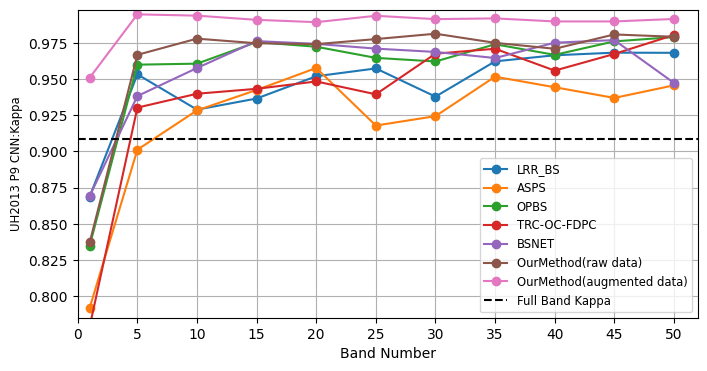

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 CNN test data

data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'LRR_BS': [0.9707, 0.9708, 0.9692, 0.9652, 0.9427, 0.9607, 0.9558, 0.9416, 0.9345, 0.9570, 0.8791,
               0.9703, 0.9753, 0.9716, 0.9696, 0.9521, 0.9647, 0.9612, 0.9513, 0.9440, 0.9583, 0.8905,
               0.9682, 0.9683, 0.9665, 0.9623, 0.9379, 0.9574, 0.9520, 0.9366, 0.9289, 0.9533, 0.8688],
    'ASPS': [0.9500, 0.9420, 0.9488, 0.9556, 0.9303, 0.9243, 0.9611, 0.9470, 0.9341, 0.9090, 0.8081,
             0.9559, 0.9499, 0.9526, 0.9611, 0.9384, 0.9292, 0.9655, 0.9530, 0.9418, 0.9157, 0.8352,
             0.9457, 0.9370, 0.9444, 0.9517, 0.9244, 0.9179, 0.9577, 0.9425, 0.9284, 0.9012, 0.7919],
    'OPBS': [0.9808, 0.9780, 0.9694, 0.9761, 0.9652, 0.9675, 0.9746, 0.9775, 0.9638, 0.9632, 0.8477,
             0.9822, 0.9776, 0.9733, 0.9775, 0.9701, 0.9696, 0.9732, 0.9690, 0.9670, 0.9614, 0.8670,
             0.9791, 0.9761, 0.9668, 0.9741, 0.9622, 0.9647, 0.9724, 0.9756, 0.9607, 0.9600, 0.8349],
    'TRC-OC-FDPC': [0.9820, 0.9700, 0.9593, 0.9733, 0.9701, 0.9443, 0.9525, 0.9478, 0.9447, 0.9358, 0.7959,
                    0.9860, 0.9739, 0.9611, 0.9764, 0.9704, 0.9515, 0.9548, 0.9537, 0.9489, 0.9450, 0.8229,
                    0.9805, 0.9674, 0.9559, 0.9710, 0.9676, 0.9395, 0.9484, 0.9433, 0.9399, 0.9303, 0.7790],
    'BSNET': [0.9515, 0.9788, 0.9771, 0.9673, 0.9712, 0.9734, 0.9764, 0.9782, 0.9611, 0.9432, 0.8794,
              0.9601, 0.9784, 0.9784, 0.9678, 0.9687, 0.9763, 0.9755, 0.9789, 0.9646, 0.9512, 0.8965,
              0.9474, 0.9770, 0.9752, 0.9646, 0.9688, 0.9711, 0.9744, 0.9763, 0.9577, 0.9383, 0.8692],
    'OurMethod(raw data)': [0.9810, 0.9824, 0.9733, 0.9778, 0.9827, 0.9794, 0.9762, 0.9768, 0.9797, 0.9694, 0.8496,
                   0.9821, 0.9812, 0.9757, 0.9816, 0.9815, 0.9794, 0.9786, 0.9773, 0.9795, 0.9735, 0.8655,
                   0.9793, 0.9809, 0.9710, 0.9751, 0.9814, 0.9777, 0.9742, 0.9748, 0.9780, 0.9668, 0.8371],
    'OurMethod(augmented data)': [0.9923,0.9907,0.9907,0.9926,0.9922,0.9942,0.9902,0.9917,0.9943,0.9952,0.9549,
0.9938,0.9923,0.9927,0.9943,0.9940,0.9955,0.9904,0.9935,0.9956,0.9963,0.9639,
0.9916, 0.9899,0.9899,0.9920,0.9915,0.9938,0.9894,0.9910,0.9939,0.9948,0.9510]
}

# Creating a DataFrame
df_uh2013_cnn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['LRR_BS', 'ASPS', 'OPBS', 'TRC-OC-FDPC', 'BSNET', 'OurMethod(raw data)','OurMethod(augmented data)']

full_bands = {'OA': 0.9157, 'AA': 0.9170, 'Kappa': 0.9085}

# Define the band_numbers variable
band_numbers = df_uh2013_cnn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_cnn[df_uh2013_cnn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.5)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 CNN:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.785, 0.9980)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()